In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [2]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

Gaussian Process Regression

In [5]:
import gpflow
import tensorflow as tf

In [6]:
import gpflow

In [7]:
from gpflow.utilities import print_summary

In [8]:
gpflow.config.set_default_summary_fmt("notebook")

MATLAB engine

In [9]:
import matlab.engine

In [10]:
eng = matlab.engine.start_matlab()

In [11]:
eng.load_system("../Simulink/polydome", background = True)

## Load weather data

Which experimental set to simulate:

In [12]:
exp_id = 'Exp2'

Copy the corresponding WDB to the model input location:

In [13]:
copyfile(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", "../Data/input_WDB.mat")

'../Data/input_WDB.mat'

In [14]:
df_wdb = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")
df_wdb.head()

,time,timestamp,zenith,azimuth,dni,dhi,OutsideTemp,Tsky_rad,relative_humidity,precipitation,cloud_index,pressure,wind_speed,wind_direction,aoi,incidence_main,incidence_second,poa_direct,poa_diffuse
0,0,201706101600,37.637775,244.184376,778.389320,153.014998,24.0,18.0,50,-9999,0.5,96300,0,-9999,37.637775,-9999,-9999,616.396540,153.014998
1,300,201706101605,38.415872,245.558388,779.663530,151.020217,24.0,18.0,50,-9999,0.5,96300,0,-9999,38.415872,-9999,-9999,610.883028,151.020217
2,600,201706101610,39.202383,246.896456,776.559233,150.272165,24.0,18.0,50,-9999,0.5,96300,0,-9999,39.202383,-9999,-9999,601.769888,150.272165
3,900,201706101615,39.996665,248.200516,767.177588,151.349615,24.0,18.0,50,-9999,0.5,96300,0,-9999,39.996665,-9999,-9999,587.720827,151.349615
4,1200,201706101620,40.798119,249.472420,762.559533,150.949974,24.0,18.0,50,-9999,0.5,96300,0,-9999,40.798119,-9999,-9999,577.270157,150.949974


In [15]:
df = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_data.pkl")
df.head()

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad
timestamp,,,,,,
2017-06-10 16:00:00+02:00,5543.500000,20.5,24.0,13.1,22.866667,769.312933
2017-06-10 16:05:00+02:00,5028.724138,20.5,24.0,13.1,22.666667,761.799900
2017-06-10 16:10:00+02:00,4546.931034,20.5,24.0,13.4,22.650000,751.934367
2017-06-10 16:15:00+02:00,4550.766667,20.5,24.0,13.4,22.650000,738.959167
2017-06-10 16:20:00+02:00,4575.310345,21.5,24.0,13.4,22.633333,728.104467


In [16]:
def load_weather_data(exp_id):
    copyfile(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", "../Data/input_WDB.mat")
    df_wdb = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")
    df = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_data.pkl")
    return df_wdb, df

In [17]:
runtime = df_wdb['time'].iloc[-1]
print(f"Experiment runtime: {runtime}")

Experiment runtime: 136500


## Simulink

Set the CARNOT simulation initial temperature `t0`

In [18]:
eng.workspace['t0'] = float(23)

Set the CARNOT simulation air exchange rate

In [19]:
np_air = np.zeros([df_wdb.shape[0], 2])
np_air[:, 0] = df_wdb['time']
np_air[:, 1] = 2.75

In [20]:
eng.workspace['air_exchange_rate'] = matlab.double(np_air.tolist())

### Generate Heat Random Input Signal

In [21]:
Pel_max = 6300
COP_heating = 5.0
COP_cooling = 5.0

Define a function for generating random signals:

In [22]:
def get_random_signal(nstep, a_range = (-1, 1), b_range = (2, 10), signal_type = 'analog'):

    a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
    b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
    b = np.round(b)
    b = b.astype(int)

    b[0] = 0

    for i in range(1,np.size(b)):
        b[i] = b[i-1]+b[i]
        
    if signal_type == 'analog':
        random_signal = np.zeros(nstep)
        # Random Signal
        i=0
        random_signal = np.zeros(nstep)
        while b[i]<np.size(random_signal):
            k = b[i]
            random_signal[k:] = a[i]
            i=i+1
        return random_signal
    elif signal_type == 'prbs':
        
        # PRBS
        a = np.zeros(nstep)
        j = 0
        while j < nstep:
            a[j] = a_range[1]
            a[j+1] = a_range[0]
            j = j+2

        i=0
        prbs = np.zeros(nstep)
        while b[i]<np.size(prbs):
            k = b[i]
            prbs[k:] = a[i]
            i=i+1
            
        return prbs
    else:
        raise NotImplementedError

In [23]:
len_signal = len(df_wdb)

random_signal = get_random_signal(len_signal, a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max), signal_type = 'analog')
prbs = get_random_signal(len_signal, a_range = (0, 5), signal_type = 'prbs')

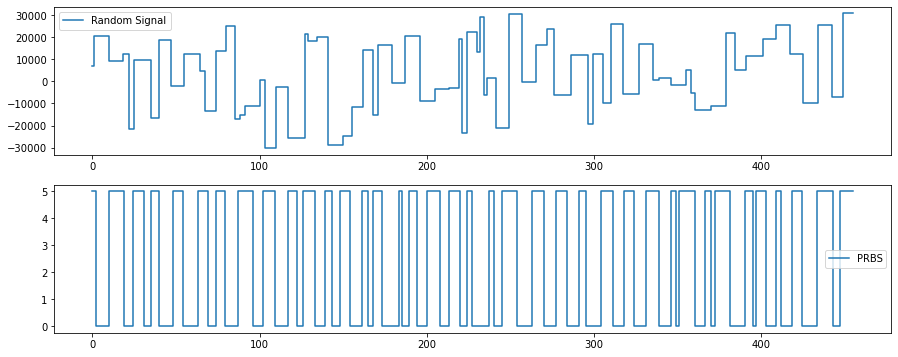

In [24]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(random_signal, drawstyle='steps',label='Random Signal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(prbs, drawstyle='steps', label='PRBS')
plt.legend()
plt.show()

In [25]:
power = np.array([df_wdb['time'], random_signal]).T

In [26]:
eng.workspace['power'] = matlab.double(power.tolist())

### Set the simulation parameters and run it

In [27]:
eng.set_param('polydome', 'StopTime', str(runtime), nargout = 0)

In [28]:
eng.workspace['result'] = eng.sim('polydome')

### Interpret the simulation results

In [29]:
def carnot_to_series(eng, start_timestamp):

    # Compile the simulation dict
    dict_simulation = {}
    dict_simulation['SimulatedTemp'] = np.asarray(eng.eval('result.SimulatedTemp.Data')).reshape(-1)
    dict_simulation['time'] = np.asarray(eng.eval('result.SimulatedTemp.Time')).reshape(-1)
    
    # Create the dataframe from dict
    df_simulation = pd.DataFrame(dict_simulation)
    df_simulation.set_index('time', inplace = True, drop = True)
    
    # Define the timestamps and set it as index
    df_simulation['timestamp'] = start_timestamp + df_simulation.index.map(lambda x: pd.Timedelta(seconds = x))
    df_simulation = df_simulation.reset_index().set_index('timestamp')
    
    # Resample the dataframe to 5 min intervals
    # Taking the mean when there are multiple points, padding with zero order when data is missing
    df_simulation = df_simulation['SimulatedTemp'].resample('5min').mean().pad()
    
    return df_simulation

In [30]:
df_simulation = carnot_to_series(eng, df.index[0])

In [31]:
df.loc[:,'SimulatedTemp'] = df_simulation
df.loc[:,'SimulatedHeat'] = power[:, 1]

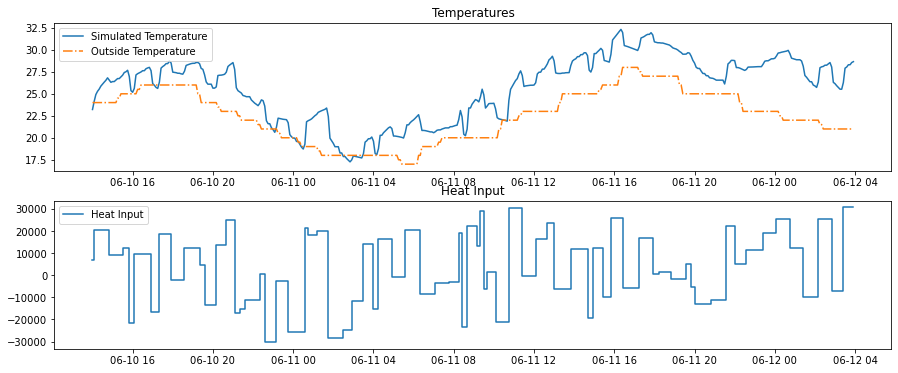

In [32]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(df['SimulatedTemp'], label = 'Simulated Temperature')
plt.plot(df['OutsideTemp'], '-.', label = 'Outside Temperature')
plt.title('Temperatures')
plt.legend()
plt.subplot(2,1,2)
plt.plot(df['SimulatedHeat'], drawstyle = 'steps', label = 'Heat Input')
plt.title('Heat Input')
plt.legend()
plt.show()

Export the resampled data-set for further use

In [33]:
df_simulation.to_pickle(f"../Data/CARNOT_output/{exp_id}_prbs_simulation_df.pkl")

In [34]:
def simulate_carnot(df_wdb, df, power_signal):
    
    power = np.array([df_wdb['time'], power_signal]).T
    runtime = df_wdb['time'].iloc[-1]
    
    eng.workspace['power'] = matlab.double(power.tolist())
    eng.set_param('polydome', 'StopTime', str(runtime), nargout = 0)
    eng.workspace['result'] = eng.sim('polydome')
    df_simulation = carnot_to_series(eng, df.index[0])
    
    return df_simulation

In [35]:
## Try an iteration

In [36]:
train_exps = ['Exp1', 'Exp3', 'Exp5', 'Exp6']
test_exps = ['Exp2', 'Exp4', 'Exp7']

In [37]:
dfs_train = []
dfs_test = []

for exp in train_exps:
    df_wdb, df = load_weather_data(exp)

    len_signal = len(df_wdb)
    rnd_power = get_random_signal(
        len_signal,
        a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max),
        signal_type = 'analog'
    )

    df_sim = simulate_carnot(df_wdb, df, rnd_power)
    df.loc[:, 'SimulatedHeat'] = rnd_power
    df.loc[:, 'SimulatedTemp'] = df_sim
    
    dfs_train.append(df)

for exp in test_exps:
    df_wdb, df = load_weather_data(exp)

    len_signal = len(df_wdb)
    rnd_power = get_random_signal(
        len_signal,
        a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max),
        signal_type = 'analog'
    )

    df_sim = simulate_carnot(df_wdb, df, rnd_power)
    df.loc[:, 'SimulatedHeat'] = rnd_power
    df.loc[:, 'SimulatedTemp'] = df_sim
    
    dfs_test.append(df)

### Trim and scale the input data

In [38]:
df.drop(columns = ['Power', 'Setpoint', 'SupplyTemp', 'InsideTemp'], inplace = True)
df.head()

,OutsideTemp,SolRad,SimulatedHeat,SimulatedTemp
timestamp,,,,
2017-07-13 20:00:00+02:00,24.0,91.714933,24245.835365,24.154504
2017-07-13 20:05:00+02:00,24.0,121.538700,24245.835365,25.009821
2017-07-13 20:10:00+02:00,24.0,101.481617,24245.835365,25.306365
2017-07-13 20:15:00+02:00,24.0,163.710150,24245.835365,25.533125
2017-07-13 20:20:00+02:00,24.0,90.039567,24245.835365,25.737816


In [39]:
from sklearn.preprocessing import MaxAbsScaler

In [40]:
w_scaler = MaxAbsScaler()
u_scaler = MaxAbsScaler()
y_scaler = MaxAbsScaler()

In [41]:
df_train = pd.concat(dfs_train)

In [42]:
np_w = df_train[['OutsideTemp', 'SolRad']]
np_u = df_train['SimulatedHeat'].to_numpy().reshape(-1, 1)
np_y = df_train['SimulatedTemp'].to_numpy().reshape(-1, 1)

In [43]:
np_w_sc = w_scaler.fit(np_w)
np_u_sc = u_scaler.fit(np_u)
np_y_sc = y_scaler.fit(np_y)

In [44]:
def get_scaled_df(df, w_scaler, u_scaler, y_scaler):
        np_w = df[['OutsideTemp', 'SolRad']]
        np_u = df['SimulatedHeat'].to_numpy().reshape(-1, 1)
        np_y = df['SimulatedTemp'].to_numpy().reshape(-1, 1)
        
        np_w_sc = w_scaler.transform(np_w)
        np_u_sc = u_scaler.transform(np_u)
        np_y_sc = y_scaler.transform(np_y)
        
        df_sc = pd.DataFrame(np.hstack([np_w_sc, np_y_sc, np_u_sc]), columns = ['OutsideTemp', 'SolRad', 'SimulatedTemp', 'SimulatedHeat'], index = df.index)

        return df_sc

In [45]:
dfs_train_sc = []
dfs_test_sc = []
for df in dfs_train:
    df_sc = get_scaled_df(df, w_scaler, u_scaler, y_scaler)
    dfs_train_sc.append(df_sc)
    
for df in dfs_test:
    df_sc = get_scaled_df(df, w_scaler, u_scaler, y_scaler)
    dfs_test_sc.append(df_sc)

## Gaussian Process Regression

### Compile training set

In [46]:
def data_to_gpr(df, lu = 2, ly = 3, dyn_in = 'SimulatedHeat', dyn_out = 'SimulatedTemp'):
    
    df_gpr = df.copy()
    df_gpr.rename(columns = {dyn_in: 'u', dyn_out: 'y'}, inplace = True)
    
    # Add the regressive inputs/outputs
    for idx in range(1, lu + 1):
        df_gpr.loc[:, f"u_{idx}"] = df_gpr['u'].shift(idx)

    for idx in range(1, ly + 1):
        df_gpr.loc[:, f"y_{idx}"] = df_gpr['y'].shift(idx)

    df_gpr.dropna(inplace = True)
    
    return df_gpr

In [47]:
dfs_gpr_train = []
for df_sc in dfs_train_sc:
    dfs_gpr_train.append(data_to_gpr(df_sc))
df_gpr_train = pd.concat(dfs_gpr_train)
df_gpr_train

,OutsideTemp,SolRad,y,u,u_1,u_2,y_1,y_2,y_3
timestamp,,,,,,,,,
2017-06-01 20:15:00+02:00,0.733333,0.070193,0.655673,-0.306488,-0.306488,-0.306488,0.658785,0.662436,0.679143
2017-06-01 20:20:00+02:00,0.733333,0.072266,0.652978,-0.306488,-0.306488,-0.306488,0.655673,0.658785,0.662436
2017-06-01 20:25:00+02:00,0.733333,0.061755,0.650362,-0.306488,-0.306488,-0.306488,0.652978,0.655673,0.658785
2017-06-01 20:30:00+02:00,0.733333,0.044350,0.647877,-0.306488,-0.306488,-0.306488,0.650362,0.652978,0.655673
2017-06-01 20:35:00+02:00,0.733333,0.033265,0.645098,-0.306488,-0.306488,-0.306488,0.647877,0.650362,0.652978
...,...,...,...,...,...,...,...,...,...
2017-07-10 05:35:00+02:00,0.600000,0.000000,0.618675,0.275838,0.275838,0.275838,0.596556,0.595280,0.594760
2017-07-10 05:40:00+02:00,0.600000,0.000000,0.645392,0.981268,0.275838,0.275838,0.618675,0.596556,0.595280
2017-07-10 05:45:00+02:00,0.600000,0.000000,0.652693,0.981268,0.981268,0.275838,0.645392,0.618675,0.596556


In [48]:
df_input_train = df_gpr_train.drop(columns = ['u', 'y'])
df_output_train = df_gpr_train['y']

In [49]:
df_input_train.head()

,OutsideTemp,SolRad,u_1,u_2,y_1,y_2,y_3
timestamp,,,,,,,
2017-06-01 20:15:00+02:00,0.733333,0.070193,-0.306488,-0.306488,0.658785,0.662436,0.679143
2017-06-01 20:20:00+02:00,0.733333,0.072266,-0.306488,-0.306488,0.655673,0.658785,0.662436
2017-06-01 20:25:00+02:00,0.733333,0.061755,-0.306488,-0.306488,0.652978,0.655673,0.658785
2017-06-01 20:30:00+02:00,0.733333,0.044350,-0.306488,-0.306488,0.650362,0.652978,0.655673
2017-06-01 20:35:00+02:00,0.733333,0.033265,-0.306488,-0.306488,0.647877,0.650362,0.652978


In [50]:
df_output_train.head()

timestamp
2017-06-01 20:15:00+02:00    0.655673
2017-06-01 20:20:00+02:00    0.652978
2017-06-01 20:25:00+02:00    0.650362
2017-06-01 20:30:00+02:00    0.647877
2017-06-01 20:35:00+02:00    0.645098
Name: y, dtype: float64

In [51]:
np_input_train = df_input_train.to_numpy()
np_output_train = df_output_train.to_numpy().reshape(-1, 1)

### Define model and kernel

In [52]:
k = (gpflow.kernels.SquaredExponential(lengthscales=([1] * np_input_train.shape[1])) + gpflow.kernels.Constant()) * gpflow.kernels.RationalQuadratic() + gpflow.kernels.SquaredExponential(lengthscales=([1] * np_input_train.shape[1])) + gpflow.kernels.Constant()
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[0].kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."
Sum.kernels[0].kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[0].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[0].kernels[1].alpha,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
Sum.kernels[1].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."
Sum.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0


In [53]:
m = gpflow.models.GPR(
    data = (np_input_train, np_output_train), 
    kernel = k, 
    mean_function = None
    )
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."
GPR.kernel.kernels[0].kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].kernels[1].alpha,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


### Train model

In [54]:
opt = gpflow.optimizers.Scipy()

In [55]:
from datetime import datetime

In [56]:
start_time = datetime.now()
opt.minimize(m.training_loss, m.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(m)

Finished fitting in 0:03:46.245137


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].kernels[0].kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0
GPR.kernel.kernels[0].kernels[0].kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[309.67385789, 480.52101642, 609.04074522..."
GPR.kernel.kernels[0].kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,5.2754077941994154e-48
GPR.kernel.kernels[0].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.0
GPR.kernel.kernels[0].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1852.9511949822117
GPR.kernel.kernels[0].kernels[1].alpha,Parameter,Softplus,,True,(),float64,392.40951113657627
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1617.2173270482824
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1216.17281517, 1102.18486422, 768.25441948..."
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,2.4218461287815772e-26
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00010706922583533073


### Evaluate performance on training data

In [57]:
nb_plts = len(dfs_gpr_train)

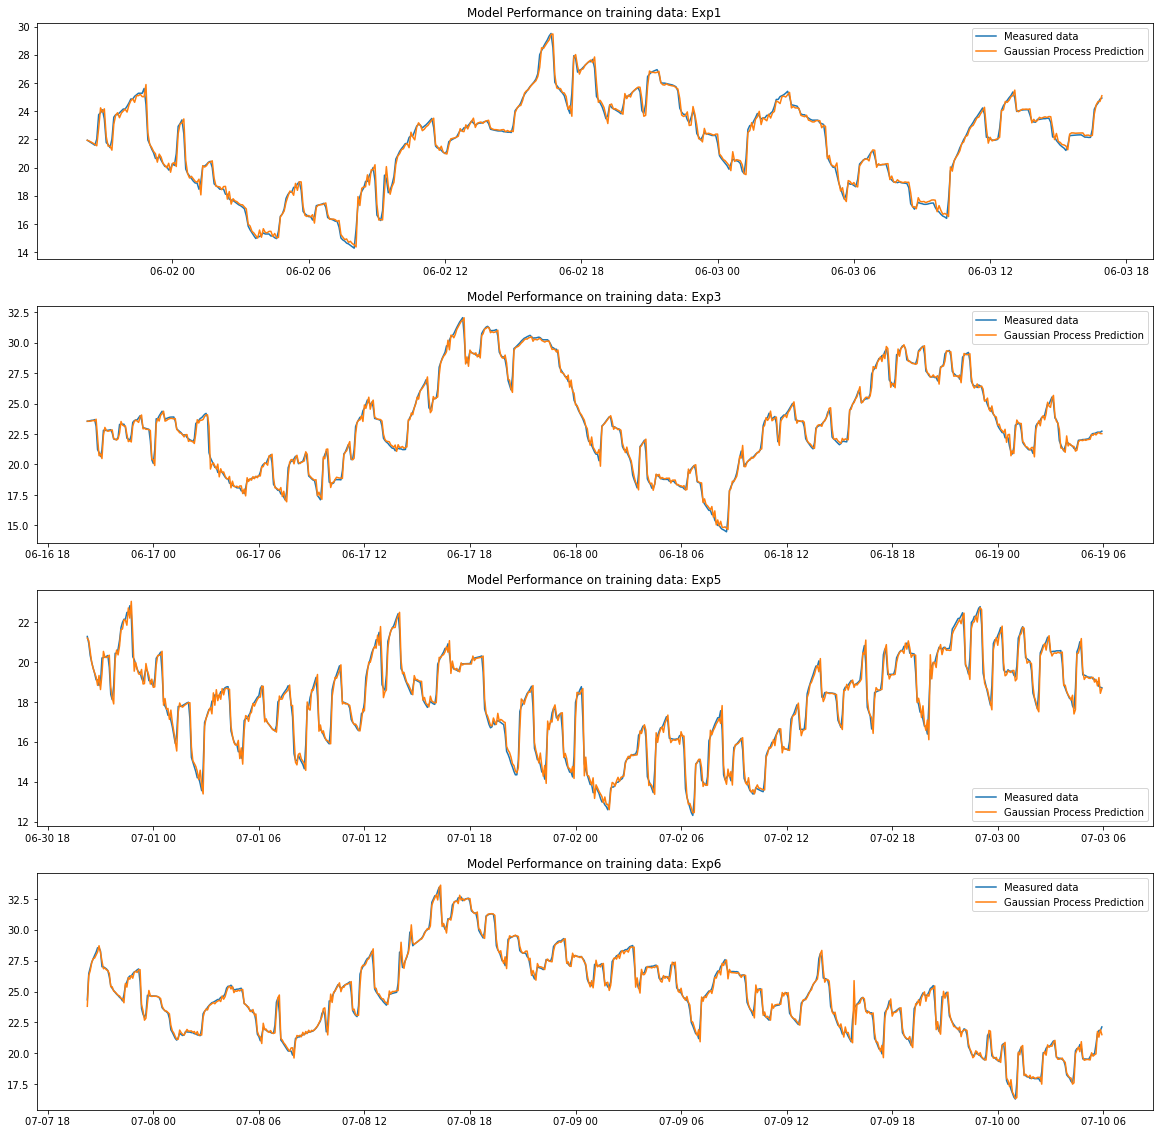

In [58]:
plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = ['y',  'u'])
    df_output_iter = df_iter['y']
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    mean = y_scaler.inverse_transform(mean)
    var = y_scaler.inverse_transform(var)
    var = y_scaler.inverse_transform(var)
    np_output_iter = y_scaler.inverse_transform(np_output_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.show()

## Evaluate performance on test data

In [59]:
dfs_gpr_test = []
for df_sc in dfs_test_sc:
    dfs_gpr_test.append(data_to_gpr(df_sc))

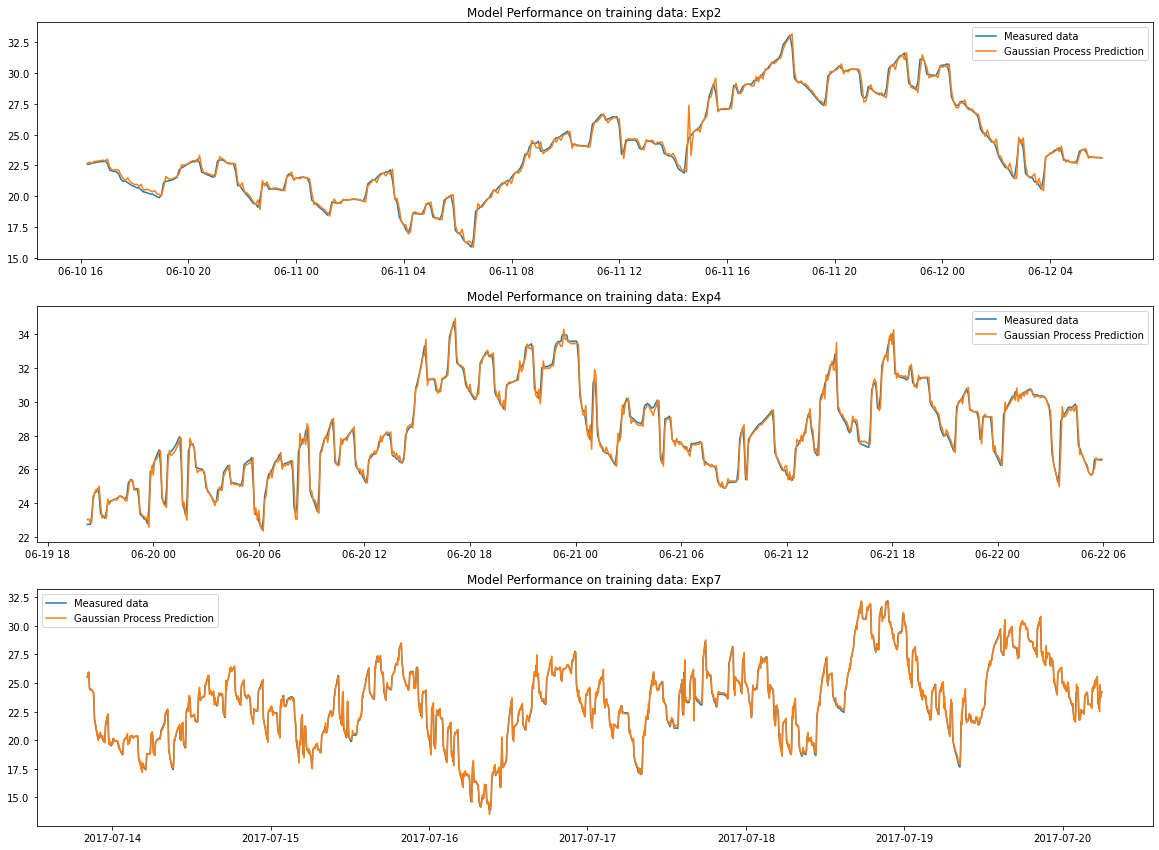

In [60]:
plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = ['y',  'u'])
    df_output_iter = df_iter['y']
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    mean = y_scaler.inverse_transform(mean)
    var = y_scaler.inverse_transform(var)
    var = y_scaler.inverse_transform(var)
    np_output_iter = y_scaler.inverse_transform(np_output_iter)
    
    plt.plot(df_iter.index, np_output_iter[:, :], label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.show()

In [61]:
def simulate_carnot_gp(df_wdb, df, power_signal, m):
    
    df_local = df.copy()
    
    power = np.array([df_wdb['time'], power_signal]).T
    runtime = df_wdb['time'].iloc[-1]
    
    eng.workspace['power'] = matlab.double(power.tolist())
    eng.set_param('polydome', 'StopTime', str(runtime), nargout = 0)
    eng.workspace['result'] = eng.sim('polydome')
    df_simulation = carnot_to_series(eng, df.index[0])
    
    df_local.loc[:,'SimulatedTemp'] = df_simulation
    df_local.loc[:,'SimulatedHeat'] = power[:, 1]
    
    df_sc = get_scaled_df(df_local, w_scaler, u_scaler, y_scaler)
    df_gpr = data_to_gpr(df_sc)

    df_input = df_gpr.drop(columns = ['u', 'y'])
    df_output = df_gpr['y']
    
    np_input_test = df_input.to_numpy()
    #np_output_test = df_output.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_y(np_input_test)
    mean = y_scaler.inverse_transform(mean)
    var = y_scaler.inverse_transform(var)
    var = y_scaler.inverse_transform(var)
        
    df_local.loc[3:, 'gpTemp'] = mean
    df_local.loc[3:, 'gpVar'] = var
    
    return df_local

In [62]:
#df_sim = simulate_carnot_gp(df_wdb, df, random_signal, m)
#df_sim.fillna(0, inplace = True)

### Export Gaussian Process Model

In [63]:
def export_gpr(path, m, w_scaler, u_scaler, y_scaler):
    m_params = gpflow.utilities.parameter_dict(m)
    pickle.dump(m_params, open(Path(path, 'gp_params.gpf'), 'wb'))
    pickle.dump(m.data, open(Path(path, 'gp_data.gpf'), 'wb'))
    pickle.dump(w_scaler, open(Path(path, 'w_scaler.pkl'), 'wb'))
    pickle.dump(u_scaler, open(Path(path, 'u_scaler.pkl'), 'wb'))
    pickle.dump(y_scaler, open(Path(path, 'y_scaler.pkl'), 'wb'))

In [64]:
export_path = Path(Path.cwd(), 'model')
export_path

PosixPath('/home/radu/Projects/Master-Project/Notebooks/model')

In [65]:
export_gpr(export_path, m, w_scaler, u_scaler, y_scaler)

In [66]:
from scipy.io import savemat

In [67]:
table_cols = df_gpr_train.columns.to_list()

In [68]:
mdict = {
    'table_cols': table_cols,
    'gpr_train': dfs_gpr_train,
    'gpr_test': dfs_gpr_test
}

In [69]:
savemat("test_mat.mat", mdict)

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


### Evaluate performance with new input and disturbances

In [70]:
df_wdb, df = load_weather_data("Exp7")
len_signal = len(df_wdb)

In [71]:
random_signal = get_random_signal(len_signal, a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max), signal_type = 'analog')

In [72]:
df_sim = simulate_carnot_gp(df_wdb, df, random_signal, m)

<ipython-input-61-8a766dcb15e4>:30: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_local.loc[3:, 'gpTemp'] = mean
<ipython-input-61-8a766dcb15e4>:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_local.loc[3:, 'gpVar'] = var


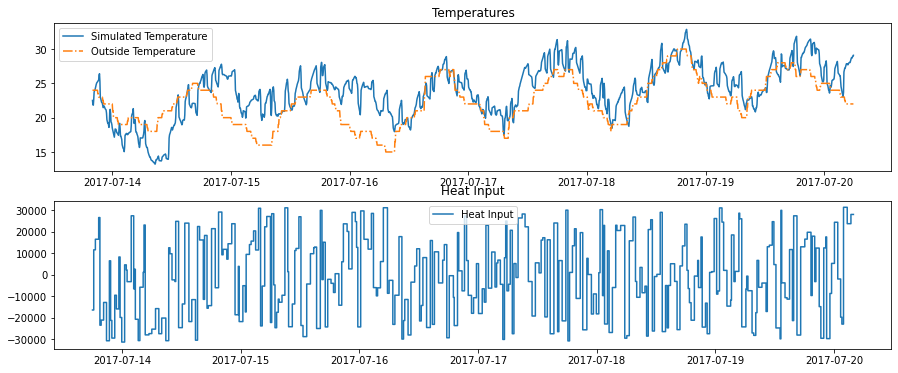

In [73]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(df_sim.index, df_sim['SimulatedTemp'], label = 'Simulated Temperature')
plt.plot(df.index, df['OutsideTemp'], '-.', label = 'Outside Temperature')
plt.title('Temperatures')
plt.legend()
plt.subplot(2,1,2)
plt.plot(df_sim['SimulatedHeat'], drawstyle = 'steps', label = 'Heat Input')
plt.title('Heat Input')
plt.legend()
plt.show()

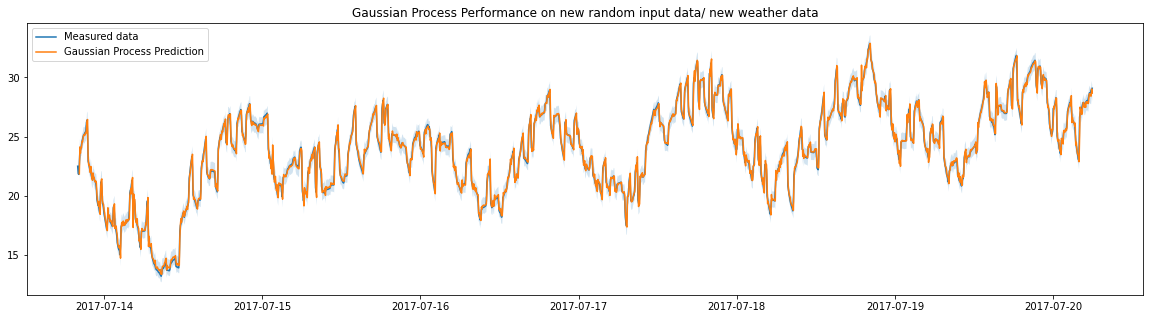

In [74]:
plt.figure(figsize = (20, 5))
plt.plot(df_sim.index, df_sim['SimulatedTemp'], label = 'Measured data')
plt.plot(df_sim.index, df_sim['gpTemp'], label = 'Gaussian Process Prediction')
plt.fill_between(
    df_sim.index, 
    df_sim['gpTemp'] - 1.96 * np.sqrt(df_sim['gpVar']),
    df_sim['gpTemp'] + 1.96 * np.sqrt(df_sim['gpVar']),
    alpha = 0.2
)
plt.legend()
plt.title("Gaussian Process Performance on new random input data/ new weather data")
plt.show()

In [75]:
### Simulate the System with constant Zero Input

In [76]:
random_signal = get_random_signal(len_signal, a_range = [0,0], signal_type = 'analog')

In [77]:
df_sim = simulate_carnot_gp(df_wdb, df, random_signal, m)

<ipython-input-61-8a766dcb15e4>:30: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_local.loc[3:, 'gpTemp'] = mean
<ipython-input-61-8a766dcb15e4>:31: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_local.loc[3:, 'gpVar'] = var


In [78]:
df_sim

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad,SimulatedTemp,SimulatedHeat,gpTemp,gpVar
timestamp,,,,,,,,,,
2017-07-13 20:00:00+02:00,18.827586,22.5,24.0,23.9,22.933333,91.714933,23.001530,0.0,NaN,NaN
2017-07-13 20:05:00+02:00,3628.965517,22.5,24.0,15.5,23.216667,121.538700,23.137768,0.0,NaN,NaN
2017-07-13 20:10:00+02:00,4391.344828,22.5,24.0,14.3,23.116667,101.481617,23.234442,0.0,NaN,NaN
2017-07-13 20:15:00+02:00,4392.466667,22.5,24.0,14.0,22.800000,163.710150,23.302663,0.0,23.363204,0.120147
2017-07-13 20:20:00+02:00,3777.482759,22.5,24.0,14.0,22.633333,90.039567,23.345263,0.0,23.391112,0.120163
...,...,...,...,...,...,...,...,...,...,...
2017-07-20 05:35:00+02:00,9.517241,22.5,22.0,23.6,22.766667,3.260000,24.331270,0.0,24.350152,0.119990
2017-07-20 05:40:00+02:00,5.666667,22.5,22.0,23.6,22.733333,3.250000,24.331270,0.0,24.350153,0.119990
2017-07-20 05:45:00+02:00,9.137931,22.5,22.0,23.6,22.750000,3.240000,24.169162,0.0,24.350154,0.119990


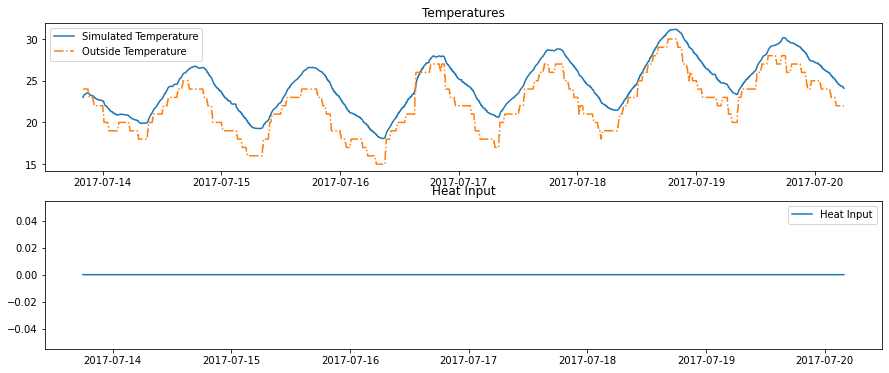

In [79]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(df_sim.index, df_sim['SimulatedTemp'], label = 'Simulated Temperature')
plt.plot(df.index, df['OutsideTemp'], '-.', label = 'Outside Temperature')
plt.title('Temperatures')
plt.legend()
plt.subplot(2,1,2)
plt.plot(df_sim['SimulatedHeat'], drawstyle = 'steps', label = 'Heat Input')
plt.title('Heat Input')
plt.legend()
plt.show()

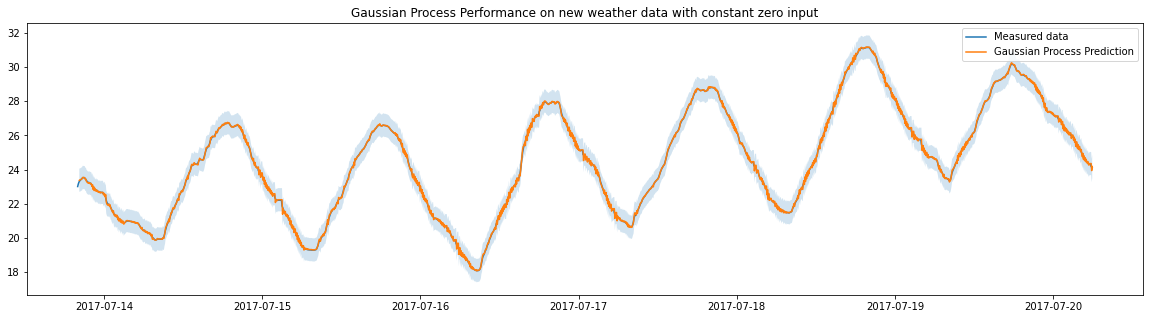

In [80]:
plt.figure(figsize = (20, 5))
plt.plot(df_sim.index, df_sim['SimulatedTemp'], label = 'Measured data')
plt.plot(df_sim.index, df_sim['gpTemp'], label = 'Gaussian Process Prediction')
plt.fill_between(
    df_sim.index, 
    df_sim['gpTemp'] - 1.96 * np.sqrt(df_sim['gpVar']),
    df_sim['gpTemp'] + 1.96 * np.sqrt(df_sim['gpVar']),
    alpha = 0.2
)
plt.legend()
plt.title("Gaussian Process Performance on new weather data with constant zero input")
plt.show()

In [81]:
### GP prediction N steps ahead

In [82]:
df_sim

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad,SimulatedTemp,SimulatedHeat,gpTemp,gpVar
timestamp,,,,,,,,,,
2017-07-13 20:00:00+02:00,18.827586,22.5,24.0,23.9,22.933333,91.714933,23.001530,0.0,NaN,NaN
2017-07-13 20:05:00+02:00,3628.965517,22.5,24.0,15.5,23.216667,121.538700,23.137768,0.0,NaN,NaN
2017-07-13 20:10:00+02:00,4391.344828,22.5,24.0,14.3,23.116667,101.481617,23.234442,0.0,NaN,NaN
2017-07-13 20:15:00+02:00,4392.466667,22.5,24.0,14.0,22.800000,163.710150,23.302663,0.0,23.363204,0.120147
2017-07-13 20:20:00+02:00,3777.482759,22.5,24.0,14.0,22.633333,90.039567,23.345263,0.0,23.391112,0.120163
...,...,...,...,...,...,...,...,...,...,...
2017-07-20 05:35:00+02:00,9.517241,22.5,22.0,23.6,22.766667,3.260000,24.331270,0.0,24.350152,0.119990
2017-07-20 05:40:00+02:00,5.666667,22.5,22.0,23.6,22.733333,3.250000,24.331270,0.0,24.350153,0.119990
2017-07-20 05:45:00+02:00,9.137931,22.5,22.0,23.6,22.750000,3.240000,24.169162,0.0,24.350154,0.119990


In [83]:
df_sim[['OutsideTemp', 'SolRad']]

,OutsideTemp,SolRad
timestamp,,
2017-07-13 20:00:00+02:00,24.0,91.714933
2017-07-13 20:05:00+02:00,24.0,121.538700
2017-07-13 20:10:00+02:00,24.0,101.481617
2017-07-13 20:15:00+02:00,24.0,163.710150
2017-07-13 20:20:00+02:00,24.0,90.039567
...,...,...
2017-07-20 05:35:00+02:00,22.0,3.260000
2017-07-20 05:40:00+02:00,22.0,3.250000
2017-07-20 05:45:00+02:00,22.0,3.240000


In [84]:
df_sc = get_scaled_df(df_sim, w_scaler, u_scaler, y_scaler)
df_gpr = data_to_gpr(df_sc)

df_input = df_gpr.drop(columns = ['u', 'y'])
df_output = df_gpr['y']

In [85]:
N_pred = 8

In [86]:
idx = 1

In [87]:
df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
df_iter

,OutsideTemp,SolRad,u_1,u_2,y_1,y_2,y_3
timestamp,,,,,,,
2017-07-13 20:20:00+02:00,0.8,0.085568,0.0,0.0,0.696457,0.694418,0.691528
2017-07-13 20:25:00+02:00,0.8,0.070732,0.0,0.0,0.697730,0.696457,0.694418
2017-07-13 20:30:00+02:00,0.8,0.066549,0.0,0.0,0.698791,0.697730,0.696457
2017-07-13 20:35:00+02:00,0.8,0.067385,0.0,0.0,0.699736,0.698791,0.697730
2017-07-13 20:40:00+02:00,0.8,0.092721,0.0,0.0,0.700498,0.699736,0.698791
2017-07-13 20:45:00+02:00,0.8,0.069557,0.0,0.0,0.701827,0.700498,0.699736
2017-07-13 20:50:00+02:00,0.8,0.035091,0.0,0.0,0.702608,0.701827,0.700498
2017-07-13 20:55:00+02:00,0.8,0.023960,0.0,0.0,0.703011,0.702608,0.701827


In [88]:
for idxx in range(N_pred - 1):
    mean, var = m.predict_y(df_iter.iloc[idxx, :].to_numpy().reshape(1, -1))
    df_iter.iloc[idxx + 1, 4] = mean.numpy().flatten()
    df_iter.iloc[idxx + 1, 5] = df_iter.iloc[idxx, 4]
    df_iter.iloc[idxx + 1, 6] = df_iter.iloc[idxx, 5]

In [89]:
df_iter

,OutsideTemp,SolRad,u_1,u_2,y_1,y_2,y_3
timestamp,,,,,,,
2017-07-13 20:20:00+02:00,0.8,0.085568,0.0,0.0,0.696457,0.694418,0.691528
2017-07-13 20:25:00+02:00,0.8,0.070732,0.0,0.0,0.699100,0.696457,0.694418
2017-07-13 20:30:00+02:00,0.8,0.066549,0.0,0.0,0.702691,0.699100,0.696457
2017-07-13 20:35:00+02:00,0.8,0.067385,0.0,0.0,0.707823,0.702691,0.699100
2017-07-13 20:40:00+02:00,0.8,0.092721,0.0,0.0,0.715442,0.707823,0.702691
2017-07-13 20:45:00+02:00,0.8,0.069557,0.0,0.0,0.727010,0.715442,0.707823
2017-07-13 20:50:00+02:00,0.8,0.035091,0.0,0.0,0.744987,0.727010,0.715442
2017-07-13 20:55:00+02:00,0.8,0.023960,0.0,0.0,0.773342,0.744987,0.727010


In [90]:
mean_iter, var_iter = m.predict_y(df_iter.to_numpy())

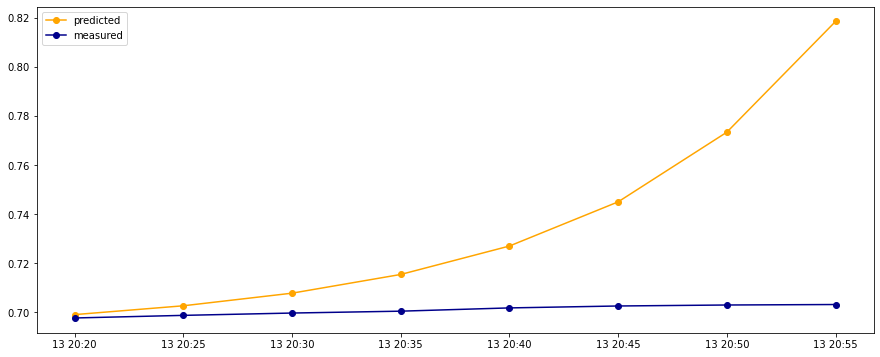

In [91]:
plt.figure()
plt.plot(df_iter.index, mean_iter.numpy(), 'o-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[idx:idx + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.legend()

In [92]:
nb_predictions = 100
N_pred = 8

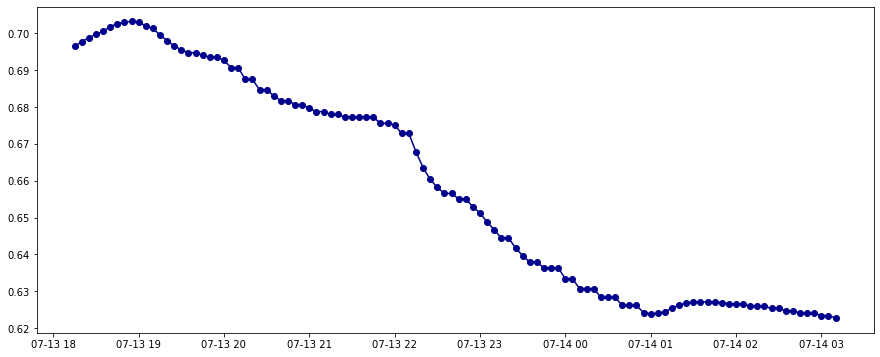

In [93]:
plt.figure()
plt.plot(df_output.iloc[:nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')

Text(0.5, 1.0, 'Prediction over 8 steps')

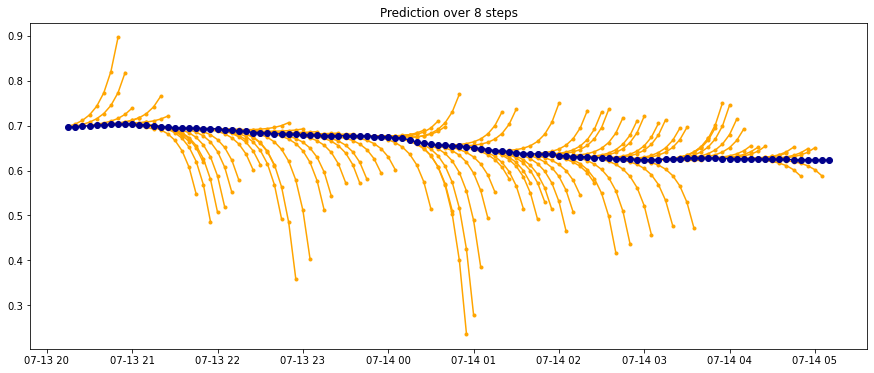

In [94]:
plt.figure()

for idx in range(nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        mean, var = m.predict_f(df_iter.iloc[idxx, :].to_numpy().reshape(1, -1))
        df_iter.iloc[idxx + 1, 4] = mean.numpy().flatten()
        df_iter.iloc[idxx + 1, 5] = df_iter.iloc[idxx, 4]
        df_iter.iloc[idxx + 1, 6] = df_iter.iloc[idxx, 5]
        
    mean_iter, var_iter = m.predict_y(df_iter.to_numpy())
    plt.plot(df_iter.index, mean_iter.numpy(), '.-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[:nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.title(f"Prediction over {N_pred} steps")
